In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# gym-DMRO demo on google-colab

# [ * ] Install gym-dmro package

Download zip from github:<br>
https://github.com/Nelson-iitp/gym-DMRO
<br>and upload to session storage

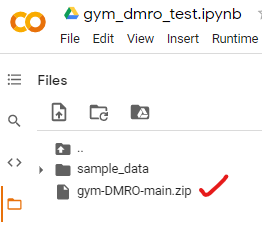

## [1] extract zip

In [2]:
import zipfile
dmro_zip='./gym-DMRO-main.zip'
dmro_dir='./'
with zipfile.ZipFile(dmro_zip, 'r') as zip_ref:
    zip_ref.extractall(dmro_dir)
print('Done!')

Done!


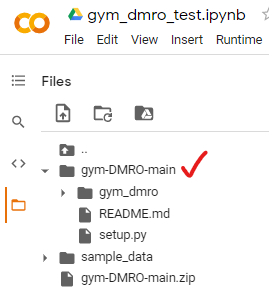

## [2] install with pip

In [3]:
pip install -e ./gym-DMRO-main

Obtaining file:///content/gym-DMRO-main
  Running setup.py develop for gym-dmro


## [3] check the package

In [4]:
pip show gym-dmro

Name: gym-dmro
Version: 0.0.1
Summary: gym environment for task placement in Edge Networks
Home-page: UNKNOWN
Author: Nelson Sharma
Author-email: None
License: UNKNOWN
Location: /content/gym-DMRO-main
Requires: gym
Required-by: 


## [4] * RESTART REQUIRED *

In [ ]:
# restart your kernel --> for colab goto Runtime > Restart runtime

## [5] Import the module

In [5]:
# import should be succesfull without any error
import gym_dmro
from gym_dmro.envs.dmro_infra import INFRA #<----- Infrastructure Class (describes Edge Network)
from gym_dmro.envs.dmro_infra import ENV   #<----- Environment Class (describes State Vectors, Utility & Reward functions)
from gym_dmro.envs.dmro_hplog import HPLOG #<----- HTML PAGE LOGGER Class (for generating HTML Reports)
print('Done!')

Done!


# [ + ] Build and Test a DMRO Environment

## [0] Global Section

In [7]:
import gym
import math
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import floyd_warshall
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# function for finding shortest path and effective Data Rate (bandwidth) b/w edge servers
def effective_bandwidth(M):
    graph = np.copy(M)  #[1:,1:]
    lm = len(graph)
    for i in range(lm):
        graph[i,i]=0
    for i in range(lm):
        for j in range(i+1, lm):
            if graph[i,j]!=0:
                graph[i,j] = 1/graph[i,j]
            graph[j,i] = graph[i,j]
    dist_matrix, predecessors = floyd_warshall(csgraph=graph, 
                                               directed=False, 
                                               return_predecessors=True)
    
    return 1/dist_matrix
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
print('Done!')

Done!


## [1] Create underlying Edge Network

Initialized New Infra ~ E / C / T : 8 / 3 / 4
Initialized New Env: DMRO


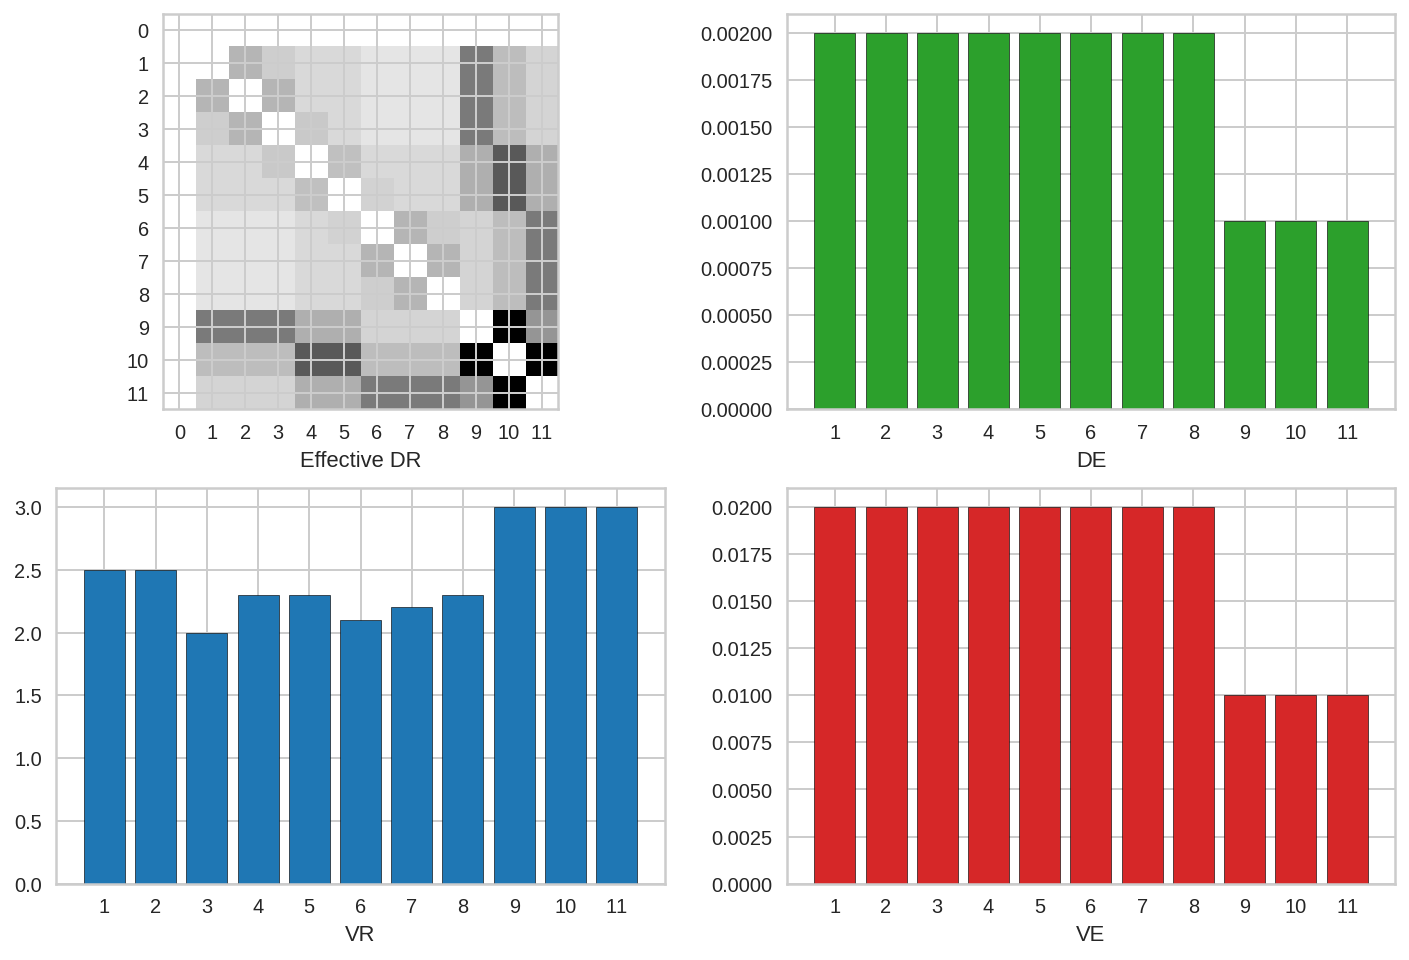

In [9]:
#------------------------------------------------------------------------------
# 1. declare edge network constants
#------------------------------------------------------------------------------
nos_edge = 8
nos_cloud = 3
nos_tasks = 4

#------------------------------------------------------------------------------
# 2. initialize the edge network
#------------------------------------------------------------------------------
Uinfra = INFRA(nos_edge, nos_cloud, nos_tasks)
Uinfra._1_init_const()
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
# 2.1. Set values for infra.DR, infra.DE, infra.VR, infra.VE (device constants)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
DR=	[
	#	iot			e1			e2			e3			e4			e5			e6			e7			e8			c9			c10			c11			#
	[	math.inf,	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			0, 			], # iot
	[	0,			math.inf,	100,		0,			0,			0,			0,			0,			0,			150,		0,			0,			], # e1
	[	0,			0,			math.inf,	100,		0,			0,			0,			0,			0,			150,		0,			0, 			], # e2
	[	0,			0,			0,			math.inf,	80,			0,			0,			0,			0,			150,		0,			0, 			], # e3
	[	0,			0,			0,			0,			math.inf,	0,			0,			0,			0,			0,			180,		0, 			], # e4
	[	0,			0,			0,			0,			0,			math.inf,	70,			0,			0,			0,			180,		0, 			], # e5
	[	0,			0,			0,			0,			0,			0,			math.inf,	100,		0,			0,			0,			150,		], # e6
	[	0,			0,			0,			0,			0,			0,			0,			math.inf,	100,		0,			0,			150,		], # e7
	[	0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	0,			0,			150,		], # e8
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	250,		0, 			], # c9
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	250,		], # c10
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	], # c11
	]
DE = [	math.inf, 	0.002, 		0.002, 		0.002,		0.002,		0.002,		0.002,		0.002,		0.002,		0.001,		0.001,		0.001		]
VE = [	math.inf,	0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.01,		0.01,		0.01		]
VR = [	math.inf,	2.50,		2.50,		2.00,		2.30,		2.30,		2.10,		2.20,		2.30,		3.00,		3.00,		3.00		]
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
DE, VR, VE = np.array(DE), np.array(VR), np.array(VE)
DR = effective_bandwidth(np.array(DR))
#print('Effective Bandwidth b/w edge servers:')
#print(DR)

# NOTE !~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# calculating effectve bandwith using floyd-warshal algorithm
# ---> transmission delay and energy consumption is calculated over the two end devices
#      which means energy consumption in handling (transmitting/routing) data 
#      between intermidiate devices in the route is ignored in utility calculation
# /NOTE !~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Uinfra._2_dev_const(DR,DE,VR,VE)
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
# 2.2. Set the IoT and workflow constants
#------------------------------------------------------------------------------
Uinfra._3_iot_limit((30, 50), (0.005, 0.010), (1.0, 1.5), (0.06, 0.10))
Uinfra._4_wf_limits((50, 100), (10,50), (10, 100))

#------------------------------------------------------------------------------
# 3. Create an environment with underlying Infrastructure that will hold the state vector
#------------------------------------------------------------------------------
Uenv = ENV(Uinfra, 
           np.array([1,1,1]),  # delay weights
           np.array([1,1,1]),  # energy weights
           init_Si=True, random_Si=True)


# *** Infrastructure and Base Environment are ready ***
#------------------------------------------------------------------------------

tik = np.arange(0,Uinfra.A)
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].set_xticks(tik)
ax[0,0].set_yticks(tik)
ax[0,0].set_xlabel('Effective DR')
ax[0,0].imshow(DR)

ax[0,1].set_xticks(tik)
ax[0,1].set_xlabel('DE')
ax[0,1].bar(tik, DE, color='tab:green')

ax[1,0].set_xticks(tik)
ax[1,0].set_xlabel('VR',)
ax[1,0].bar(tik, VR, color='tab:blue')

ax[1,1].set_xticks(tik)
ax[1,1].set_xlabel('VE')
ax[1,1].bar(tik, VE, color='tab:red')

plt.show()
#------------------------------------------------------------------------------

# [ + ] Create the gym-dmro environment

In [10]:
#%%
#------------------------------------------------------------------------------
# 4. Create the gym-dmro environment
#    ----> there are 4 different environments for 4 different reward functions
#------------------------------------------------------------------------------

#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env1 = gym.make('gym_dmro:dmro-v1')
env1._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env2 = gym.make('gym_dmro:dmro-v2')
env2._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env3 = gym.make('gym_dmro:dmro-v3')
env3._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env4 = gym.make('gym_dmro:dmro-v4')
env4._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#------------------------------------------------------------------------------
print('Done!')
#------------------------------------------------------------------------------

Initialized Empty DMRO Env_v1, call _init_(arg_env) to continue
Initialized Empty DMRO Env_v2, call _init_(arg_env) to continue
Initialized Empty DMRO Env_v3, call _init_(arg_env) to continue
Initialized Empty DMRO Env_v4, call _init_(arg_env) to continue
Done!


# [ + ] Simulate an Environment

## [1] Select Environment and Render mode

In [12]:
# select environment 
env = env3

# select a render mode
# 0=text  1=graphical(full state)  2=graphical(placement only)
rmode = 1

# simulation parameters
nos_episodes = 2
nos_timesteps = env.env.T


## [2] Start Simulation

[Start of Simulation]


EPISODE: 1 / 2


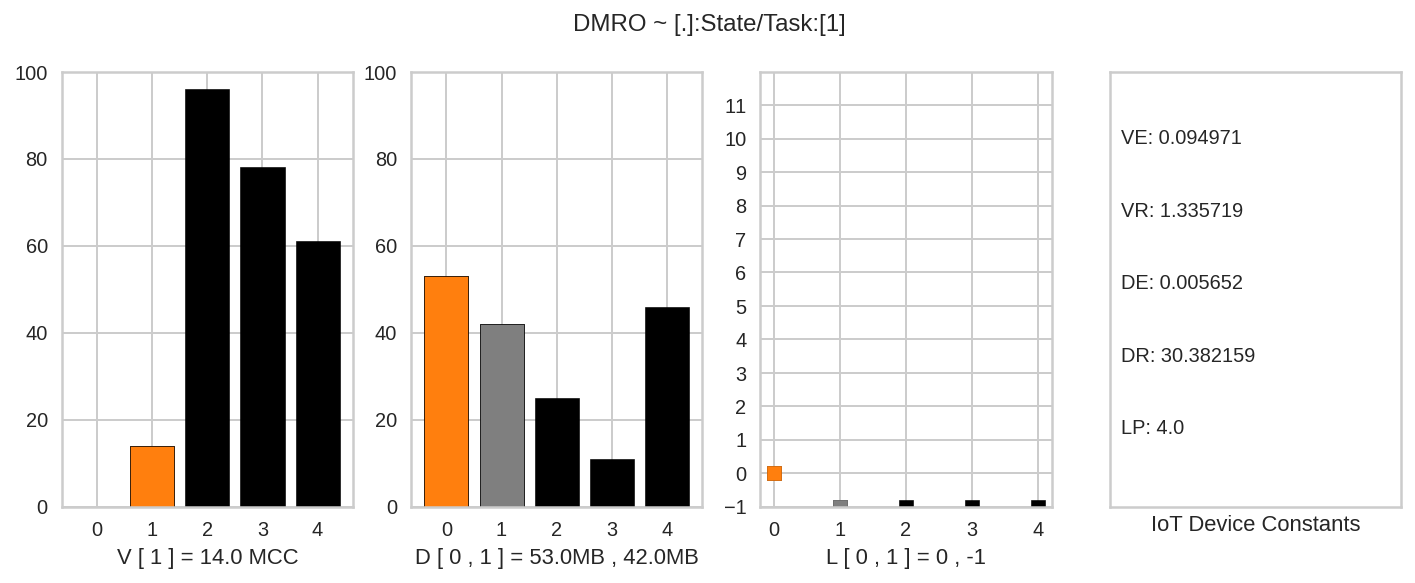


TimeStep: 1 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
1
	Action Taken:   	 1
	Reward Recieved:	 -8.674222601465258
	In Final State?:	 False


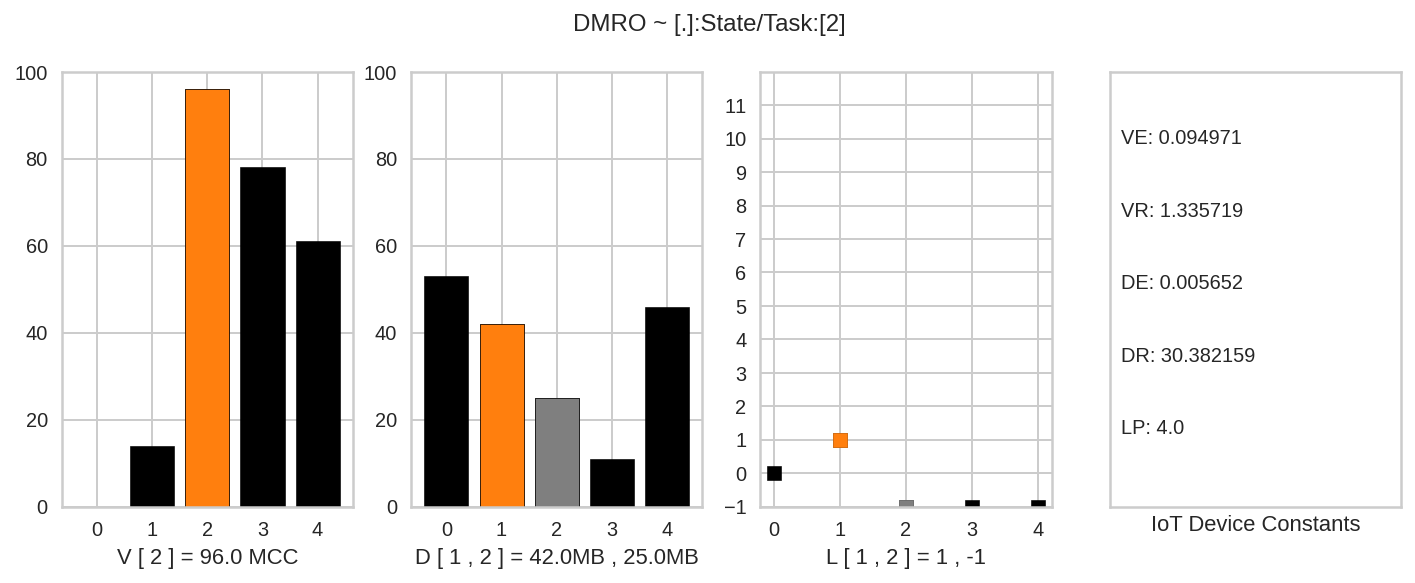


TimeStep: 2 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
2
	Action Taken:   	 2
	Reward Recieved:	 -40.874
	In Final State?:	 False


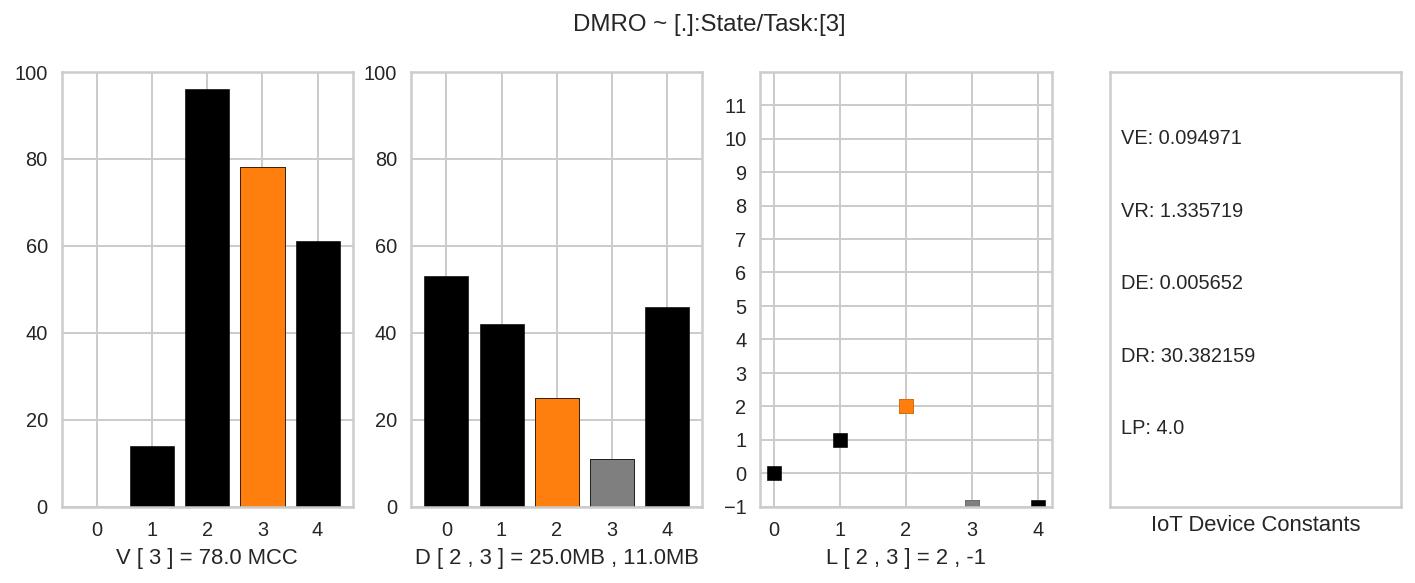


TimeStep: 3 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
3
	Action Taken:   	 3
	Reward Recieved:	 -40.882
	In Final State?:	 False


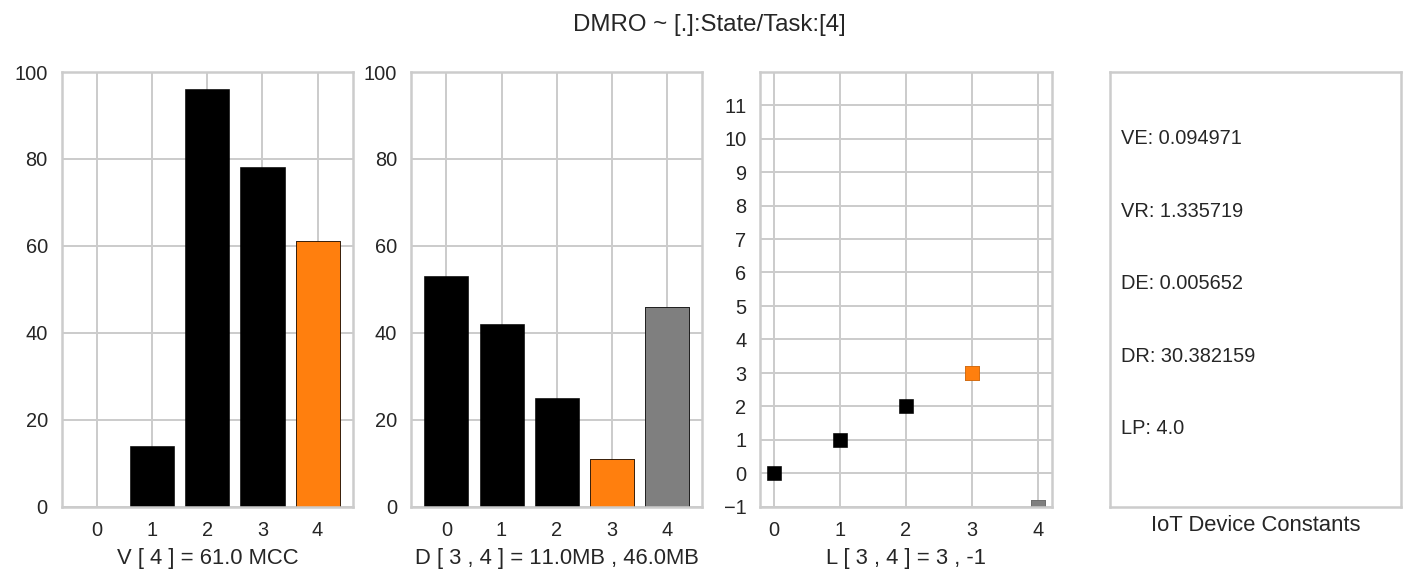


TimeStep: 4 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
8
	Action Taken:   	 8
	Reward Recieved:	 -30.350674470071297
	In Final State?:	 True


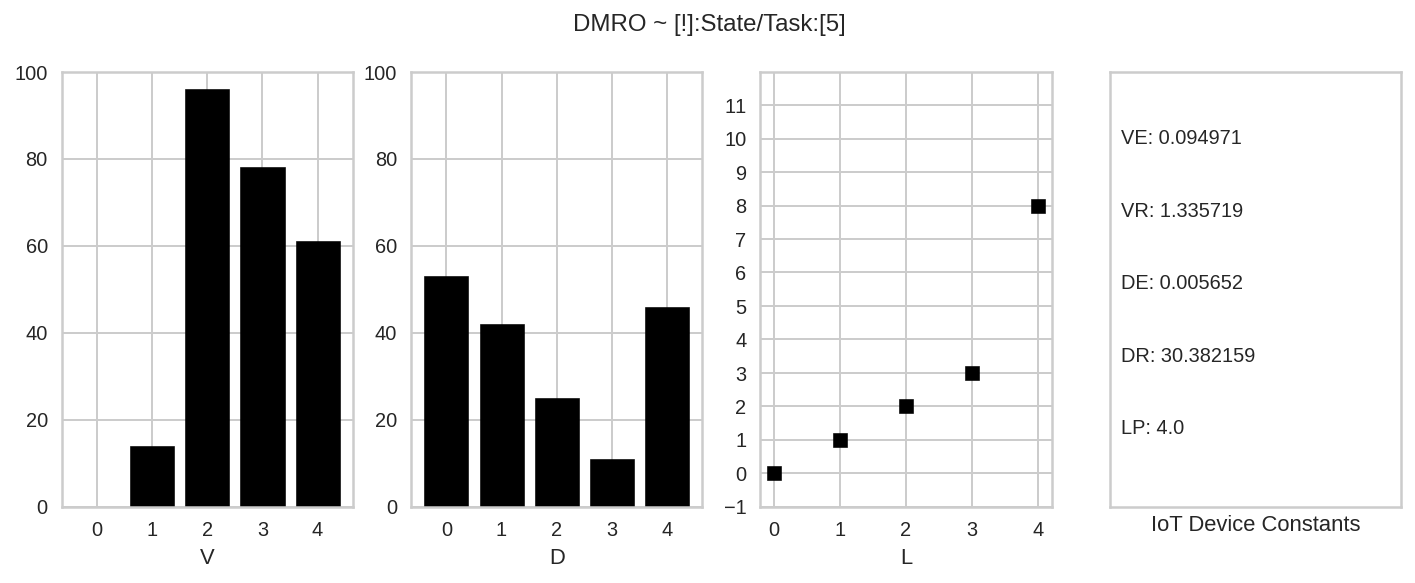

Episode finished after 4 timesteps

EPISODE: 2 / 2


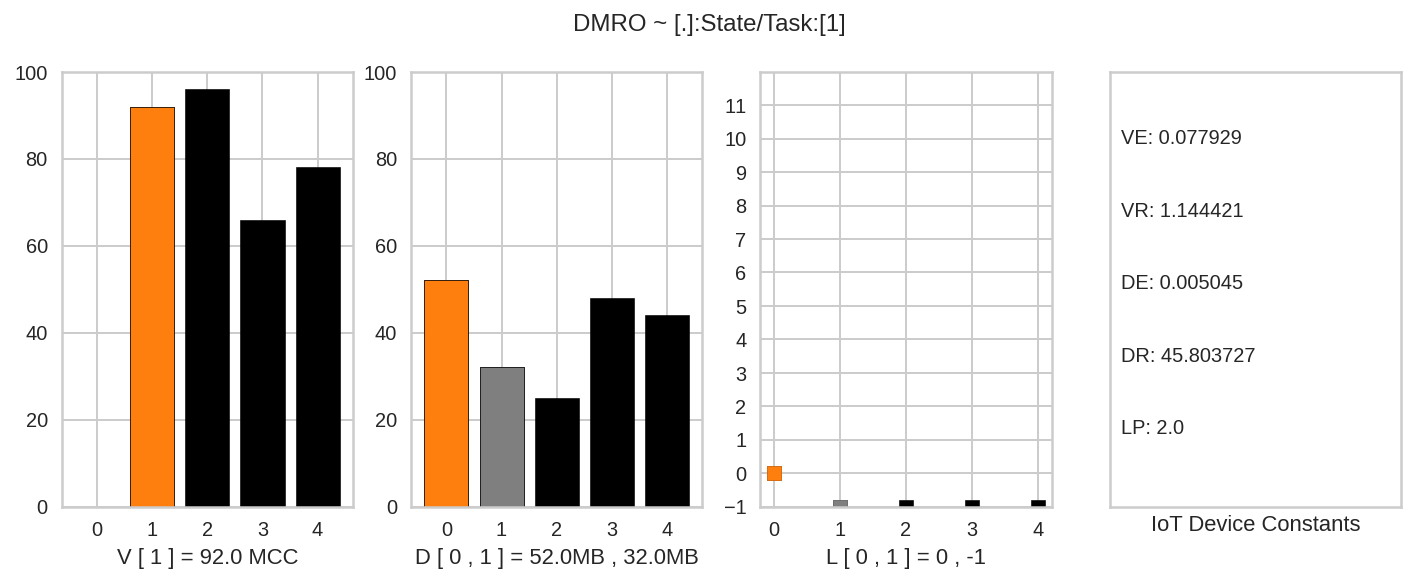


TimeStep: 1 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
3
	Action Taken:   	 3
	Reward Recieved:	 -49.66327879510766
	In Final State?:	 False


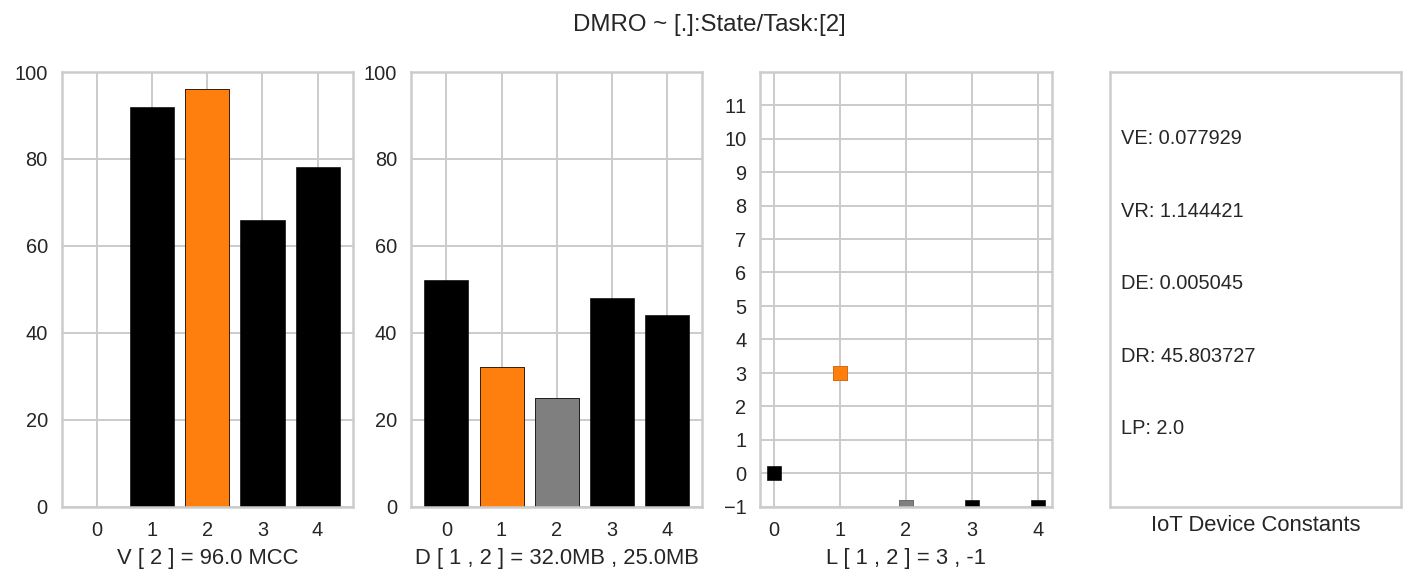


TimeStep: 2 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
4
	Action Taken:   	 4
	Reward Recieved:	 -44.173130434782614
	In Final State?:	 False


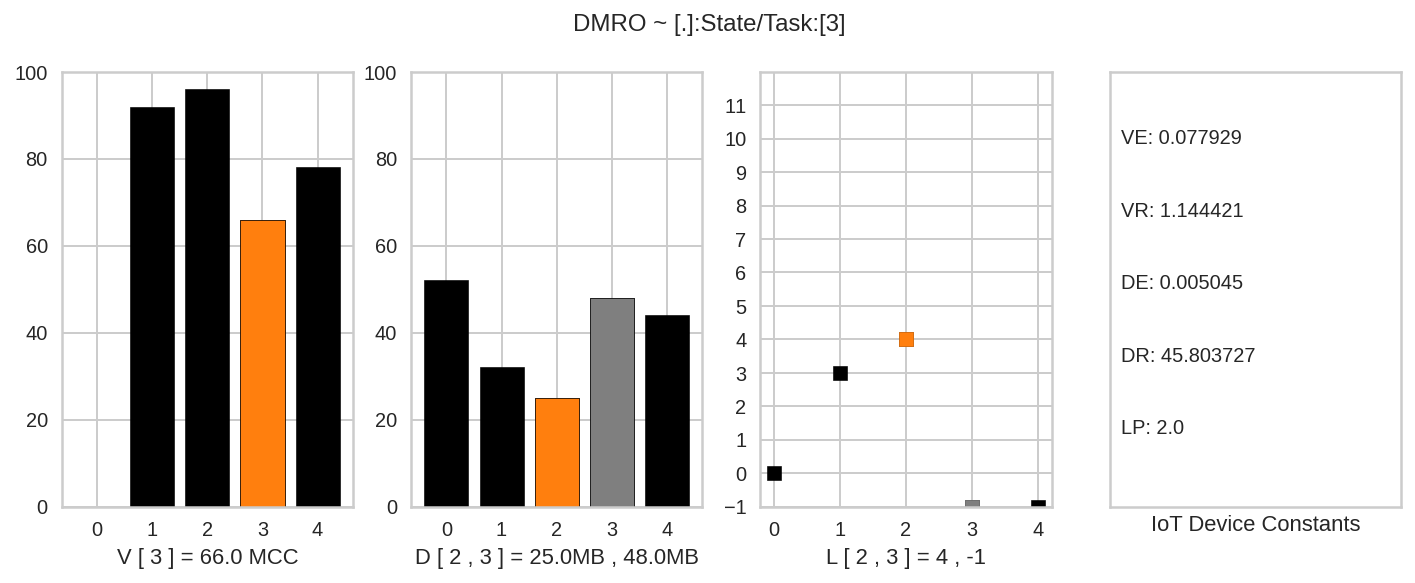


TimeStep: 3 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
5
	Action Taken:   	 5
	Reward Recieved:	 -30.439429951690826
	In Final State?:	 False


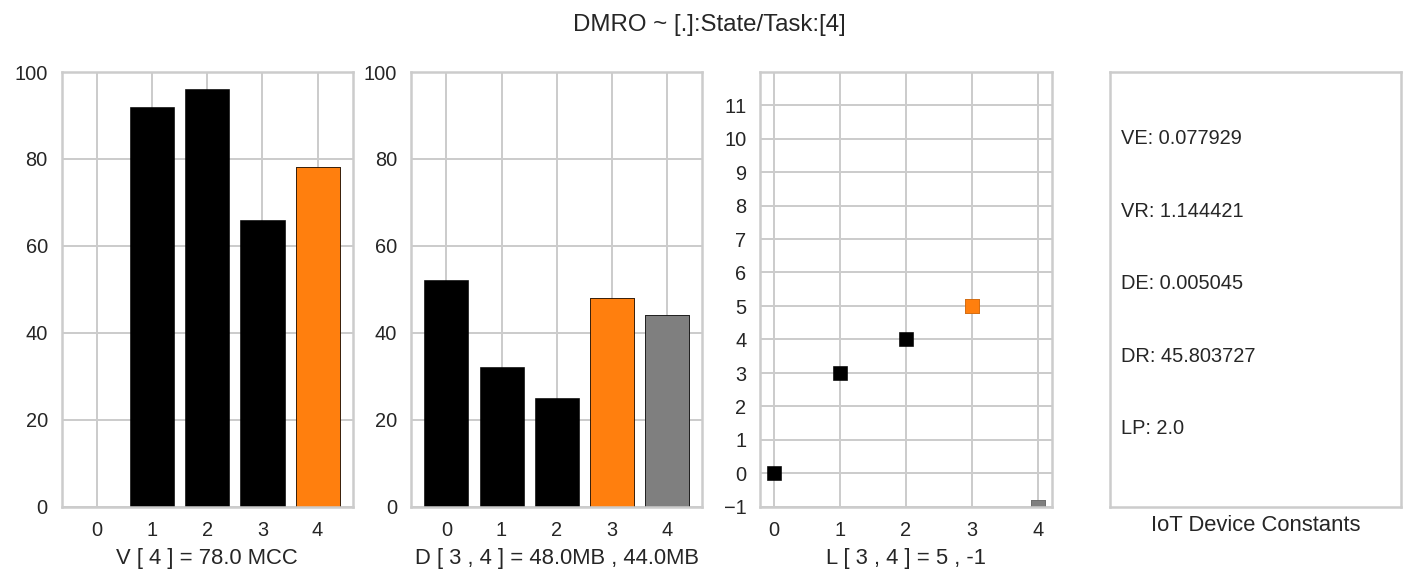


TimeStep: 4 / 4

 User Input ---> Take an Action b/w [ 0 , 11 ]
6
	Action Taken:   	 6
	Reward Recieved:	 -41.47185861417534
	In Final State?:	 True


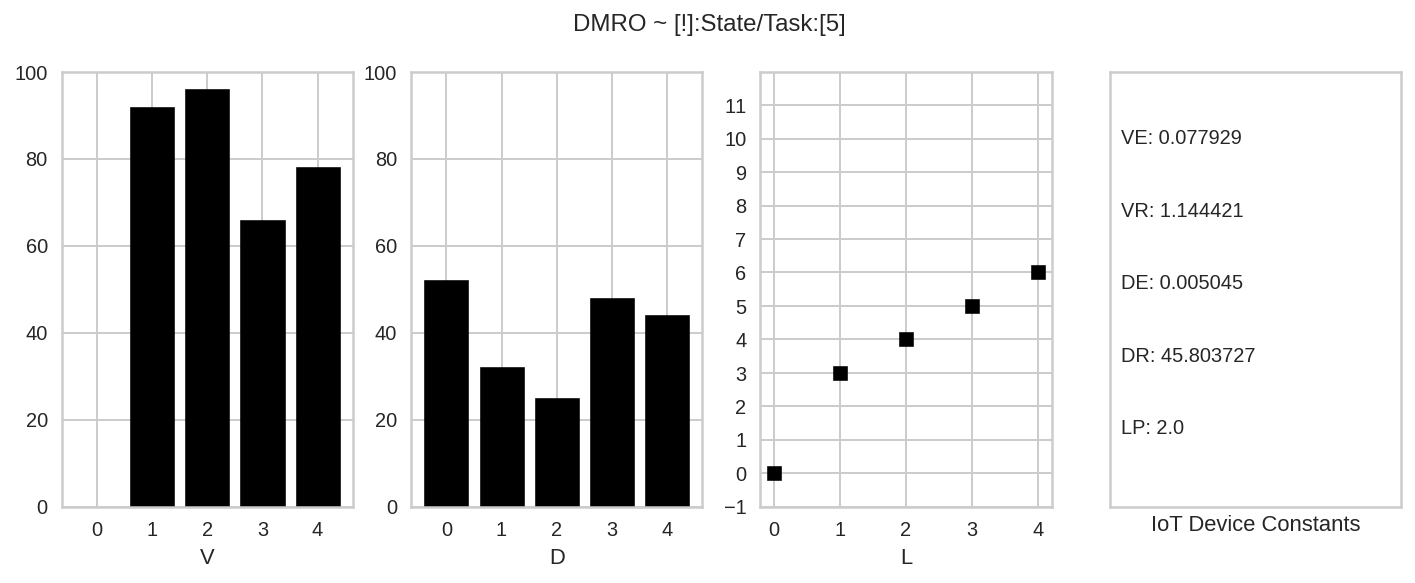

Episode finished after 4 timesteps

[End of Simulation]


In [13]:
print('[Start of Simulation]\n')
# simulation over episodes
for i_episode in range(nos_episodes):
    print('\nEPISODE:',i_episode+1,'/', nos_episodes)
    
    # randomize initial state on each episode
    observation = env.reset(randomize=True)
    
    # render Initial State
    env.render(mode=rmode)
    do_break=False
    
    # start stepping through environment
    for t in range(nos_timesteps):
        print('\nTimeStep:', t+1,'/',nos_timesteps)    
        
        #current state vector
        #print('Current State Vector:', observation)
        
        # take an action--------------------------------------
        
        # option 1 - random sample from action space
        #action = env.action_space.sample()
        
        # option 2 - ask user to input action
        print('\n User Input ---> Take an Action b/w [ 0 ,', env.env.A-1,']')
        action = int(input())
        # break if user wants to
        if action>env.env.A-1:
            print('\n!! BREAK !!\n')
            do_break=True
            break
        
        # ----------------------------------------------------
        print('\tAction Taken:   \t',action)
        
        # call step() to go to next state and recieve reward
        observation, reward, done, info = env.step(action)
        #observation, reward, done, info = env.step(action, [0,1,2,3])
        
        print('\tReward Recieved:\t', reward)
        print('\tIn Final State?:\t',done)
        
        #next state vector
        #print('Next State Vector:', observation)
        
        # render after taking action
        env.render(mode=rmode)
        
        # break on end of timesteps
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    
    # break if user wants to
    if do_break:
        print('\n!! HALT !!\n')
        break
        
env.close()
print('\n[End of Simulation]')

# Done!